In [36]:
from ema_workbench import load_results

In [37]:
results = load_results('./results/tests.tar.gz')

In [38]:
experiments, outcomes = results

In [39]:
filtered_outcomes = {key:value for key, value in outcomes.items() if not key.startswith("Damage_")}

In [40]:
filtered_outcomes

{'Brick_TransportCost': array([  3.94923934e+08,   1.82806255e+09,   4.33168158e+08,
          1.26841214e+09,   3.03748149e+09,   2.61911929e+09,
          1.85956068e+09,   1.37615425e+09,   5.00407205e+08,
          2.90514322e+09]),
 'Brick_TravelTime': array([  3055887.34456977,  14011239.08561374,   1699753.99727498,
          4294265.53732541,  10408745.76785986,  14070405.75739298,
         17811038.39256185,  13363071.93652288,   3613237.24902027,
         14073209.8702024 ]),
 'Brick_UnsatisfiedDemand': array([ 1944070.23167878,  1265092.94186066,  2115997.5072305 ,
         1821322.4788567 ,  1113470.90925426,   856434.03537621,
         1458746.92120545,  1386063.38644869,  1870155.8288114 ,
          977932.69414429]),
 'Food_TransportCost': array([  2.10461351e+09,   2.47554854e+09,   2.81338800e+09,
          6.45256133e+09,   4.13675458e+09,   2.52969367e+09,
          2.75310012e+09,   2.24766320e+09,   1.76243496e+09,
          4.35198575e+09]),
 'Food_TravelTime': ar

In [41]:
pd.DataFrame.from_records(experiments)

,Brick_rail,Brick_road,Brick_water,Flood_area,Flood_depth,Flood_duration,Food_rail,Food_road,Food_water,Garment_rail,...,waterway_1_Wmax,waterway_2_Tm,waterway_2_Wmax,waterway_3_Tm,waterway_3_Wmax,waterway_4_Tm,waterway_4_Wmax,scenario_id,policy,model
0,0.933153,0.293760,0.837591,1992-0190,1.663639,71.296161,0.696797,0.953940,0.626246,0.056716,...,0.702789,0.971105,0.706022,1.700862,0.657465,1.110218,0.753348,0,None,BGD
1,0.851319,0.962547,0.326997,1998-0203,3.035534,39.554980,0.724635,0.599846,0.720327,0.340013,...,0.634607,2.733292,0.875527,3.478743,0.857176,1.597948,0.700612,1,None,BGD
2,0.274618,0.084062,0.958788,2005-0590,2.191743,86.860136,0.983222,0.421413,0.911474,0.810396,...,0.645040,3.250259,0.811206,0.883383,0.794502,3.028659,0.925429,2,None,BGD
3,0.707678,0.325172,0.613054,1992-0190,3.822516,35.183277,0.123759,0.894578,0.038767,0.923465,...,0.883185,2.966544,0.970420,1.292365,0.720937,0.102920,0.910582,3,None,BGD
4,0.472084,0.705822,0.185675,NON_FLOODED,3.746968,42.587991,0.488529,0.607512,0.194656,0.195626,...,0.955765,0.230888,0.774339,0.160615,0.708913,3.290131,0.619125,4,None,BGD
5,0.190233,0.467895,0.079222,2005-0590,4.576191,76.149066,0.589573,0.703028,0.229989,0.402864,...,0.750365,0.437376,0.647137,3.111944,0.628772,2.751478,0.878877,5,None,BGD
6,0.341574,0.529248,0.591936,2012-0175,4.780245,63.258448,0.217114,0.018275,0.545862,0.539696,...,0.813873,1.332252,0.939110,0.655686,0.916062,2.196775,0.775441,6,None,BGD
7,0.588636,0.861523,0.719710,1998-0203,2.907433,82.633044,0.340592,0.116217,0.857228,0.267723,...,0.789829,2.305386,0.749490,1.996843,0.989573,2.016532,0.984227,7,None,BGD
8,0.619676,0.180263,0.222488,NON_FLOODED,1.087351,57.856934,0.831777,0.384195,0.335265,0.787348,...,0.989343,1.533436,0.630888,2.615464,0.942651,0.619254,0.643389,8,None,BGD
9,0.080866,0.687097,0.420492,2012-0175,2.426648,50.845683,0.033218,0.258895,0.469008,0.602325,...,0.861695,1.843025,0.894373,2.165696,0.827126,0.925658,0.832668,9,None,BGD


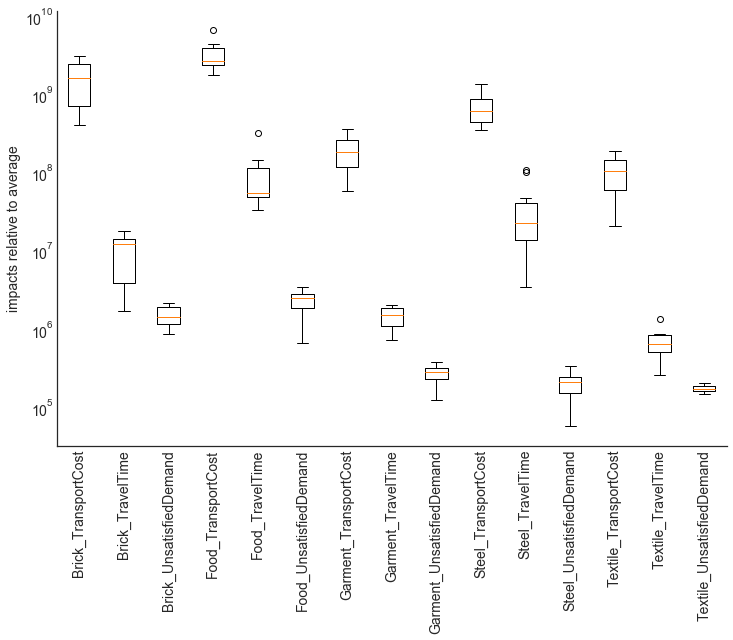

In [42]:
sns.set_style('white')

fig, ax = plt.subplots()

labels, data = zip(*[(key,filtered_outcomes[key]) for key in 
                     sorted(filtered_outcomes.keys())])
data = [v for k,v in zip(labels, data)]
ax.boxplot(data, labels=labels)
ax.set_ylabel('impacts relative to average')
ax.set_yscale('log')
plt.xticks(rotation=90)
sns.despine()

change_fontsize(fig, 14)
save_fig(fig, './results/figs/', 'boxplot')

plt.show()

In [14]:
from ema_workbench.analysis.feature_scoring import get_feature_scores_all

In [43]:
import numpy.lib.recfunctions as rcf

names = rcf.get_names(experiments.dtype)
remove = [entry for entry in names if entry.endswith('Wmax') or entry.endswith('Tm')]
remove += ['model', 'policy', 'scenario_id']

filtered_experiments = rcf.drop_fields(experiments, asrecarray=True, 
                                       drop_names=remove)
filtered_outcomes = {key:value for key, value in outcomes.items() if 
                     key.startswith("Damage_")}
n, d = zip(*filtered_outcomes.items())
filtered_experiments = rcf.append_fields(filtered_experiments, n, d, 
                                         asrecarray=True)


In [44]:
filtered_outcomes = {key:value for key, value in outcomes.items() if not
                     key.startswith("Damage_")}
data = get_feature_scores_all(filtered_experiments, filtered_outcomes)

In [51]:
data = data[sorted(data.columns)]

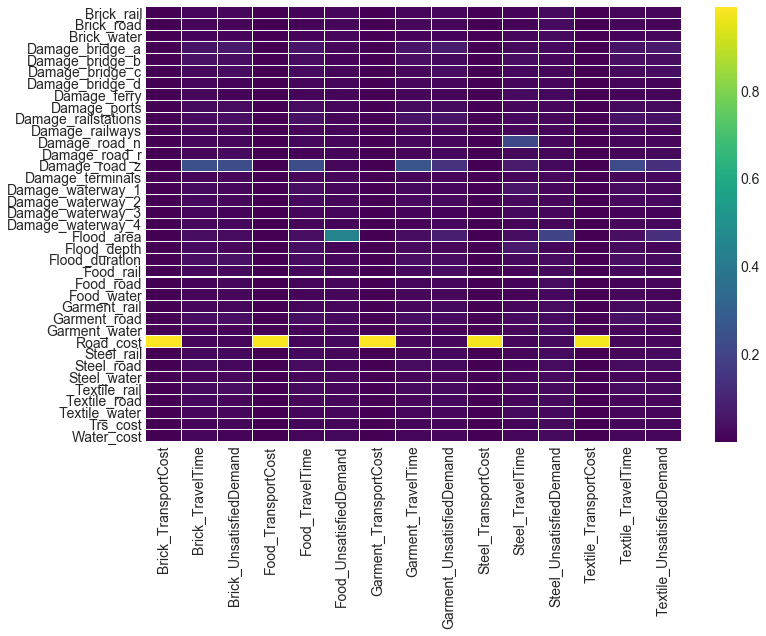

In [56]:
sns.heatmap(data, cmap='viridis',linewidths=.01)

fig = plt.gcf()
change_fontsize(fig)
save_fig(fig, './results/figs/', '_fs')

plt.show()

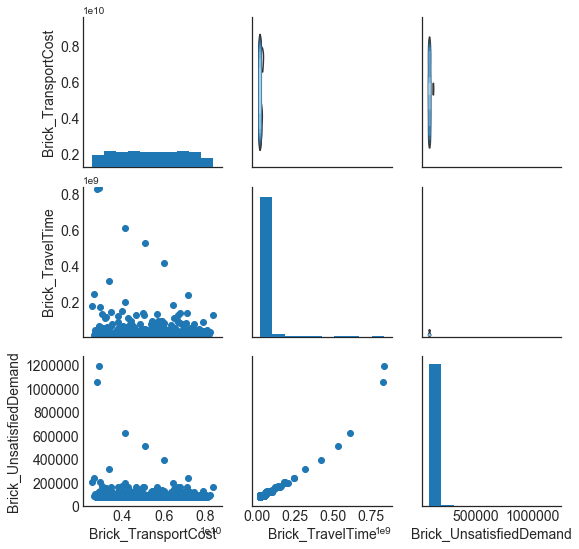

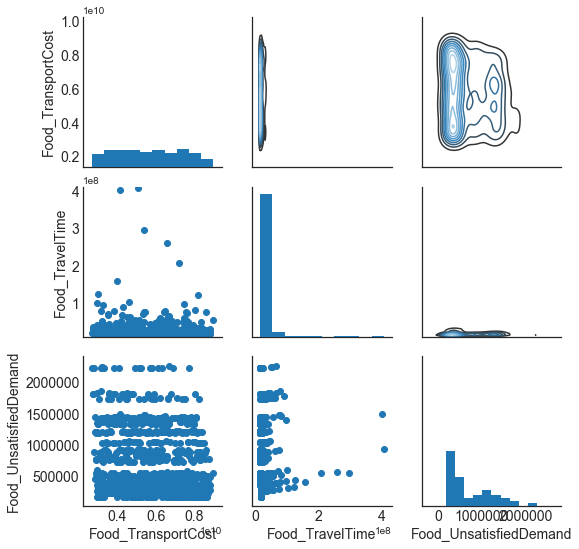

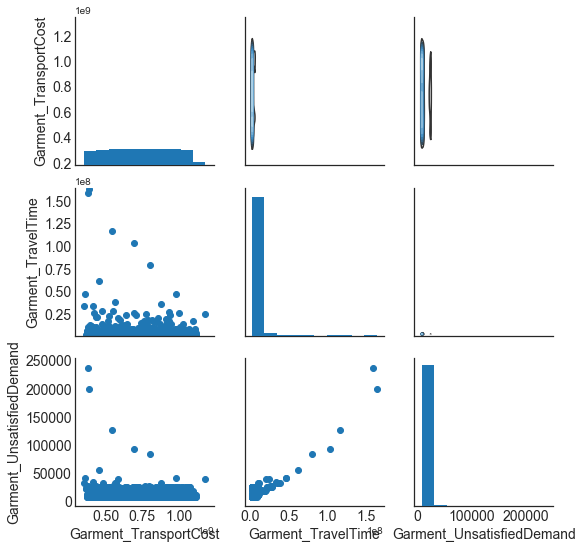

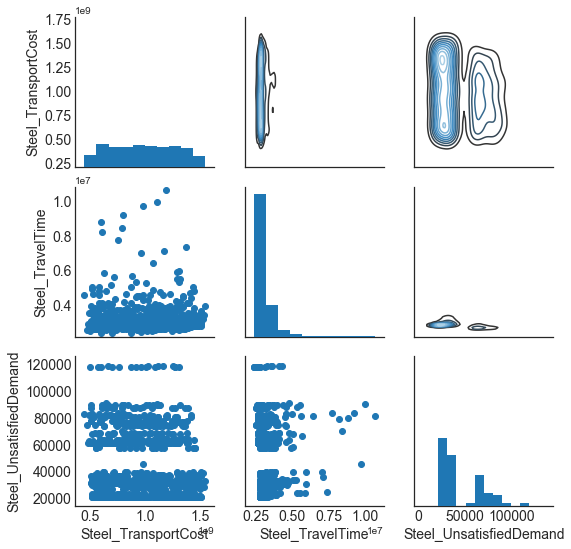

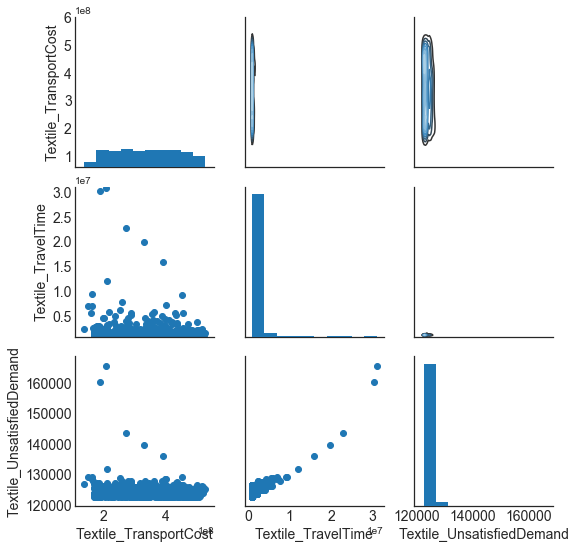

In [61]:
data = pd.DataFrame.from_dict(filtered_outcomes)

for good in ["Brick", "Food", "Garment", "Steel", "Textile"]:
    columns = [entry for entry in data.columns if entry.startswith(good)]
    grid = sns.PairGrid(data, vars=columns)
    grid.map_lower(plt.scatter)
    grid.map_upper(sns.kdeplot, cmap="Blues_d")
    grid.map_diag(plt.hist)
    
    fig = plt.gcf()
    change_fontsize(fig)
    save_fig(fig, './results/figs/', '_{}'.format(good))
    
    plt.show()

In [ ]:
data = pd.DataFrame.from_dict(filtered_outcomes)

for otype in ["Cost", "Time", "Demand", ]:
    columns = [entry for entry in data.columns if entry.endswith(otype)]
    columns = sorted(columns)
    grid = sns.PairGrid(data, vars=columns)
    grid.map_lower(plt.scatter)
    grid.map_upper(sns.kdeplot, cmap="Blues_d")
    grid.map_diag(plt.hist)
    
    plt.show()

In [ ]:
data = pd.DataFrame.from_dict(filtered_outcomes)
sns.heatmap(np.abs(data.corr()), annot=True, cmap='viridis')
plt.show()


In [ ]:
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
from sklearn import preprocessing

# Created on 11 Sep 2017
#
# .. codeauthor::jhkwakkel <j.h.kwakkel (at) tudelft (dot) nl>

__all__ = []

def setup_parallel_plot(labels, minima, maxima, fs=14):
    sns.set_style('white')
    #labels is a list, minima and maxima pd series
    nr_columns = len(labels)
    fig = plt.figure()
    axes = [] 
    tick_labels = {}
    
    # we need one axes less than the shape
    for i, label in enumerate(labels[:-1]):
        i += 1
        ax = fig.add_subplot(1,nr_columns-1,i,  ylim=(-0.1,1.1))
        axes.append(ax)
        ax.set_xlim([i,i+1])
        ax.xaxis.set_major_locator(ticker.FixedLocator([i]))
        ax.xaxis.set_ticklabels([labels[i-1]], rotation=90, fontsize=fs)
        ax.xaxis.set_tick_params(bottom=False, top=False)
        
        #let's put our own tick labels
        ax.yaxis.set_ticks([])
        max_label = "{:.2f}".format(maxima[label])
        min_label = "{:.2f}".format(minima[label])
        max_label= ax.text(i, 1.01, max_label, va="bottom",
                           ha="center", fontsize=fs)
        min_label= ax.text(i, -0.01, min_label, va="top",
                           ha="center", fontsize=fs)
        tick_labels[label] = (min_label, max_label)
        
        ax.spines['left'].set_bounds(0, 1)
        ax.spines['right'].set_bounds(0, 1)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

    
    # for the last axis, we need 2 ticks (also for the right hand side
    ax.xaxis.set_major_locator(ticker.FixedLocator([i, i+1]))
    ax.xaxis.set_ticklabels(labels[i-1:i+1], fontsize=fs)

    label = labels[-1]
    max_label = "{:.2f}".format(maxima[label])
    min_label = "{:.2f}".format(minima[label])
    max_label = ax.text(i+1, 1.01, max_label, va="bottom",
                        ha="center", fontsize=fs)
    min_label = ax.text(i+1, -0.01, min_label, va="top",
                        ha="center", fontsize=fs)
    tick_labels[label] = (min_label, max_label)

    
    # add the tick labels to the rightmost spine
    for tick in ax.yaxis.get_major_ticks():
        tick.label2On=True
    
    # stack the subplots together
    plt.subplots_adjust(wspace=0)
    
    return fig, axes, tick_labels


class ParcoordsFigure(object):
    
    def __init__(self, data, groupby=None, drop=True, color=None):
        '''
        
        Parameters
        ----------
        data :  pd.Dataframe
        groupby : str, optional
        drop : bool, optional
               if true, remove groupby column from data to be visualized
        color : valid mpl color, or list of colors
        
        
        '''
        
        super(ParcoordsFigure, self).__init__()
        self.data = data
        self.fs = 14
        
        # recode data
        
        # normalize data 
        min_max_scaler = preprocessing.MinMaxScaler()
        self.norm_data = pd.DataFrame(min_max_scaler.fit_transform(self.data),
                                     columns=self.data.columns)
        
        labels = list(data.columns.values)
        if groupby and drop:
            labels.remove(groupby)
        
        fig, axes, tick_labels = setup_parallel_plot(labels, data.min(), 
                                                     data.max(), fs=self.fs)
            
        self.fig = fig
        self.axes = axes
        self.ticklabels = tick_labels
        self.lines = pd.DataFrame(np.zeros((data.values.shape[0], 
                                            len(self.axes)), dtype=np.object),
                            columns=[x for x in range(len(self.axes))])
        
        if color is None:
            colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        else:
            # check natur of colors (list or 1 color this is tricky...)
            colors = color
        
        if groupby:
            colors = itertools.cycle(colors)
            some_identifiers = []
            for groupname, group in self.norm_data.groupby(groupby):
                c = next(colors)
                self._plot(axes, labels, group, c=c)
                some_identifiers.append((groupname, 
                                         plt.Line2D([0,1], [0,1], c=c)))
                
            labels, some_identifiers = zip(*some_identifiers)
            axes[-1].legend(some_identifiers, labels, loc=2,
                            borderaxespad=0.1, fontsize=self.fs,
                            bbox_to_anchor=(1.3, 0.95))
        else:
            self._plot(axes, labels, self.norm_data, c=color)

    def _plot(self, axes, labels, data, c=None):
        j=-1
        for ax, label_i, label_j in zip(axes, labels[:-1], labels[1::]):
            plotdata = data.loc[:,[label_i, label_j]]
            j += 1
            x = np.tile([j+1,j+2], (plotdata.shape[0], 1))
            for index, row in plotdata.iterrows():
                line = ax.plot([j+1, j+2], row.values, c=c)
                self.lines.loc[index, j] = line
            
    def set_lims(self, axis, minimum, maximum):
        # axis is string or list of strings
        # min and max, scalar or iterable of scalars
        pass
    
    
    def brush(self, axis, brush):
        if isinstance(axis, str):
            axis = [axis]
            brush = [brush]
        assert len(axis)==len(brush)
        logical = np.ones(self.data.shape[0], dtype=np.bool)
        print(logical.shape)
        for a, brushlim in zip(axis, brush):
            datum = self.data.loc[:,a]
            logical = logical & (datum >= brushlim[0]) & (datum <= brushlim[1])
        inverse = logical==False
        
        for i in range(len(self.axes)):
                lines = self.lines.loc[inverse, i]
                for line in lines:
                    line[0].set_color('lightgrey')
                    line[0].set_zorder(1)

    
    def set_ticks(self, axis, ticks):
        pass
    
    
    def set_ticklabels(self, axis, ticks):
        pass
    
    
    def invert_axis(self, axis):
        '''flip direction for specified axis
        
        Parameters
        ----------
        axis : str or list of str
        
        '''
        
        if isinstance(axis, str):
            self._invert_axis(axis)
        else:
            for entry in axis:
                self._invert_axis(entry)
           
    def _invert_axis(self, axis):
        ids = self._get_axes_ids(axis)
        
        if len(ids) == 1:
            id = ids[0]
            if id == 0:
                index = 0
            else:
                index = 1

            ax = self.axes[id]
            self._update_plot_data(axis, ax, index)
        else:
            left, right = ids
            self._update_plot_data(axis, self.axes[left], 1)
            self._update_plot_data(axis, self.axes[right], 0)
            
        
    def _update_plot_data(self, axis, ax, index):
        lines = ax.get_lines()
        for line in lines:
            ydata = line.get_data()[1]
            ydata[index] = 1- ydata[index]
            line.set_ydata(ydata)
            
        if index==0:
            labels = self.ticklabels[axis]

            for label in labels:
                x, y = label.get_position()
                if y == -0.01:
                    y = 1.01
                    label.set_va('bottom')
                else:
                    y = -0.01
                    label.set_va('top')
                label.set_position((x,y))
                
                
    def _get_axes_ids(self, column):
        index = self.data.columns.get_loc(column) 
        if index == 0 or index >= (len(self.axes)): 
            index = min(index, (len(self.axes)-1)) 
            return (index,)
        else:
            other_index = index-1
            return other_index, index
    

In [ ]:
for entry in ['Steel', 'Brick', 'Food', 'Garment', 'Textile']:
    data = pd.DataFrame.from_dict({k:v for k,v in filtered_outcomes.items() if k.startswith(entry)})
    fig = ParcoordsFigure(data)
    plt.show()

In [ ]:
for entry in ['Cost', 'Time', 'Demand']:
    data = pd.DataFrame.from_dict({k:v for k,v in filtered_outcomes.items() if k.endswith(entry)})
    fig = ParcoordsFigure(data)
    plt.show()